# Investment Portfolio Optimization 
In this notebook I do two things.
The first aim is to simulate random portfolios of four major stocks and to find optimal portfolios in terms of risk and Sharpe ratio. 
The second aim is to simulate random portfolios of correlated and uncorrelated stock and to see how portfolio returns are impacted.

## Portfolio of four major stock

In [1]:
# Importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import pyfolio as pf
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/alexandergeiger/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Importing data for four major stocks from quandl

quandl.ApiConfig.api_key = 'is9J6Gdep3c_XZpxQu8h'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2013-1-1', 'lte': '2018-3-26' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-26,GOOGL,1054.09
1,2018-03-23,GOOGL,1026.55
2,2018-03-22,GOOGL,1053.15
3,2018-03-21,GOOGL,1094.00
4,2018-03-20,GOOGL,1095.80


In [3]:
# Transform the dataframe into a more handy format

df = data.set_index ('date')
table = df.pivot(columns = 'ticker')
columns = table.columns.get_level_values(1)
table.columns = columns
table.head()

ticker,AAPL,AMZN,FB,GOOGL
date,,,,
2013-01-02,71.195748,257.3100,28.0000,362.744758
2013-01-03,70.296565,258.4800,27.7700,362.955409
2013-01-04,68.338996,259.1500,28.7600,370.127548
2013-01-07,67.937002,268.4592,29.4213,368.512563
2013-01-08,68.119845,266.3800,29.0607,367.785318


ticker      AAPL      AMZN        FB     GOOGL
ticker                                        
AAPL    0.000228  0.000074  0.000090  0.000072
AMZN    0.000074  0.000335  0.000159  0.000138
FB      0.000090  0.000159  0.000411  0.000132
GOOGL   0.000072  0.000138  0.000132  0.000198


ticker
AAPL     0.000789
AMZN     0.001536
FB       0.001526
GOOGL    0.000909
dtype: float64

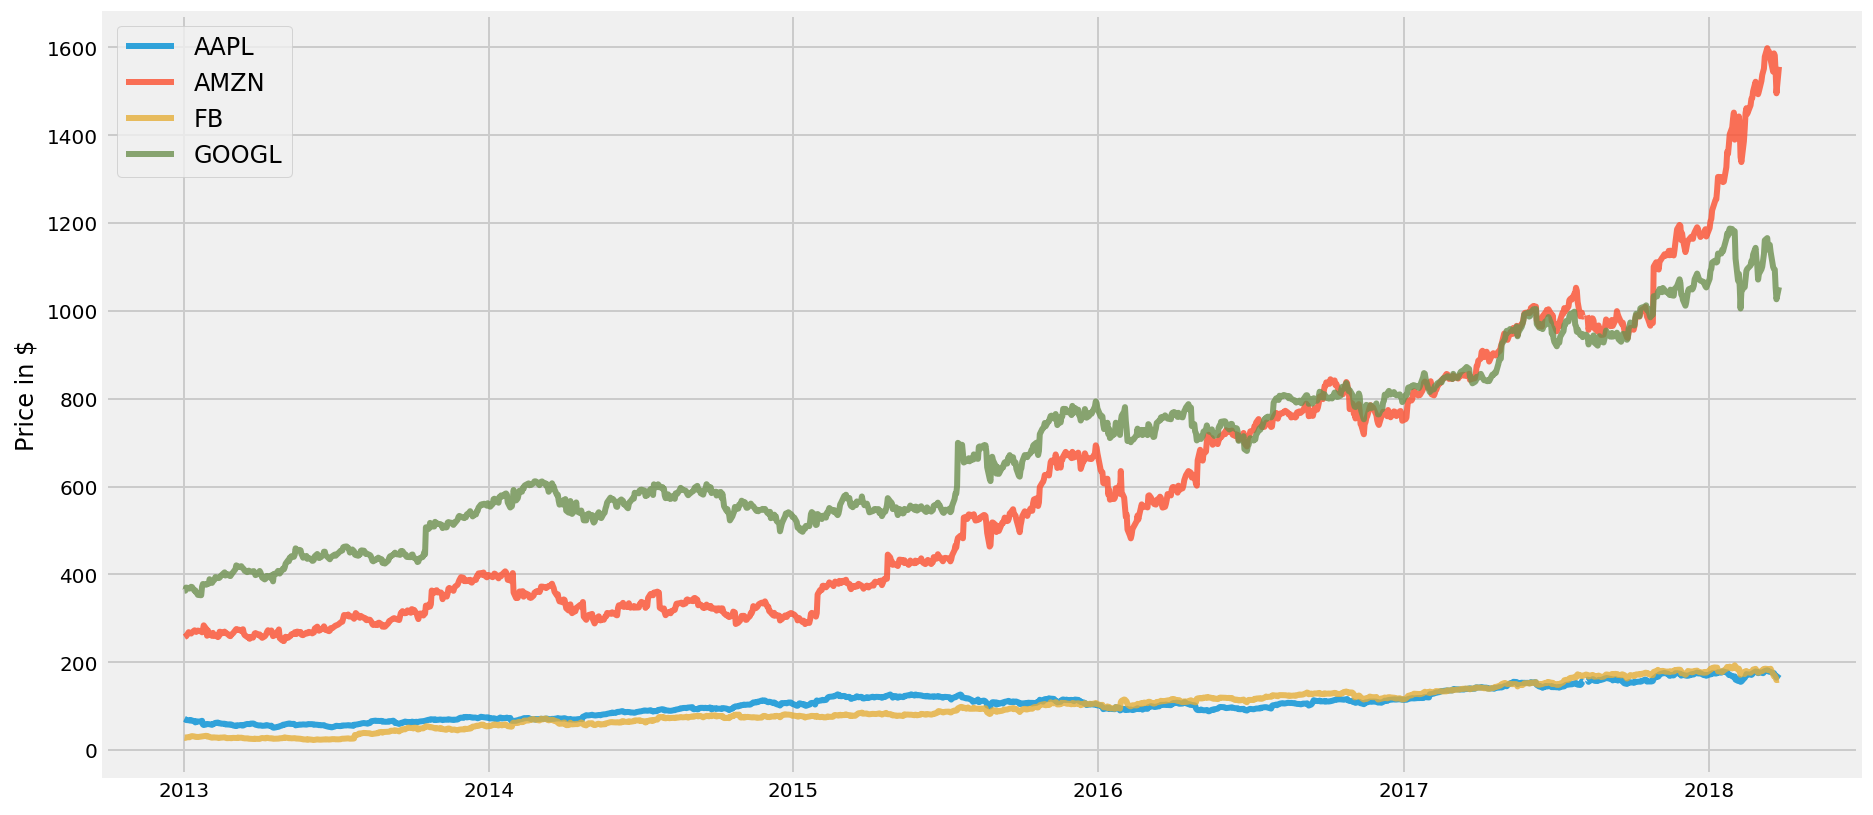

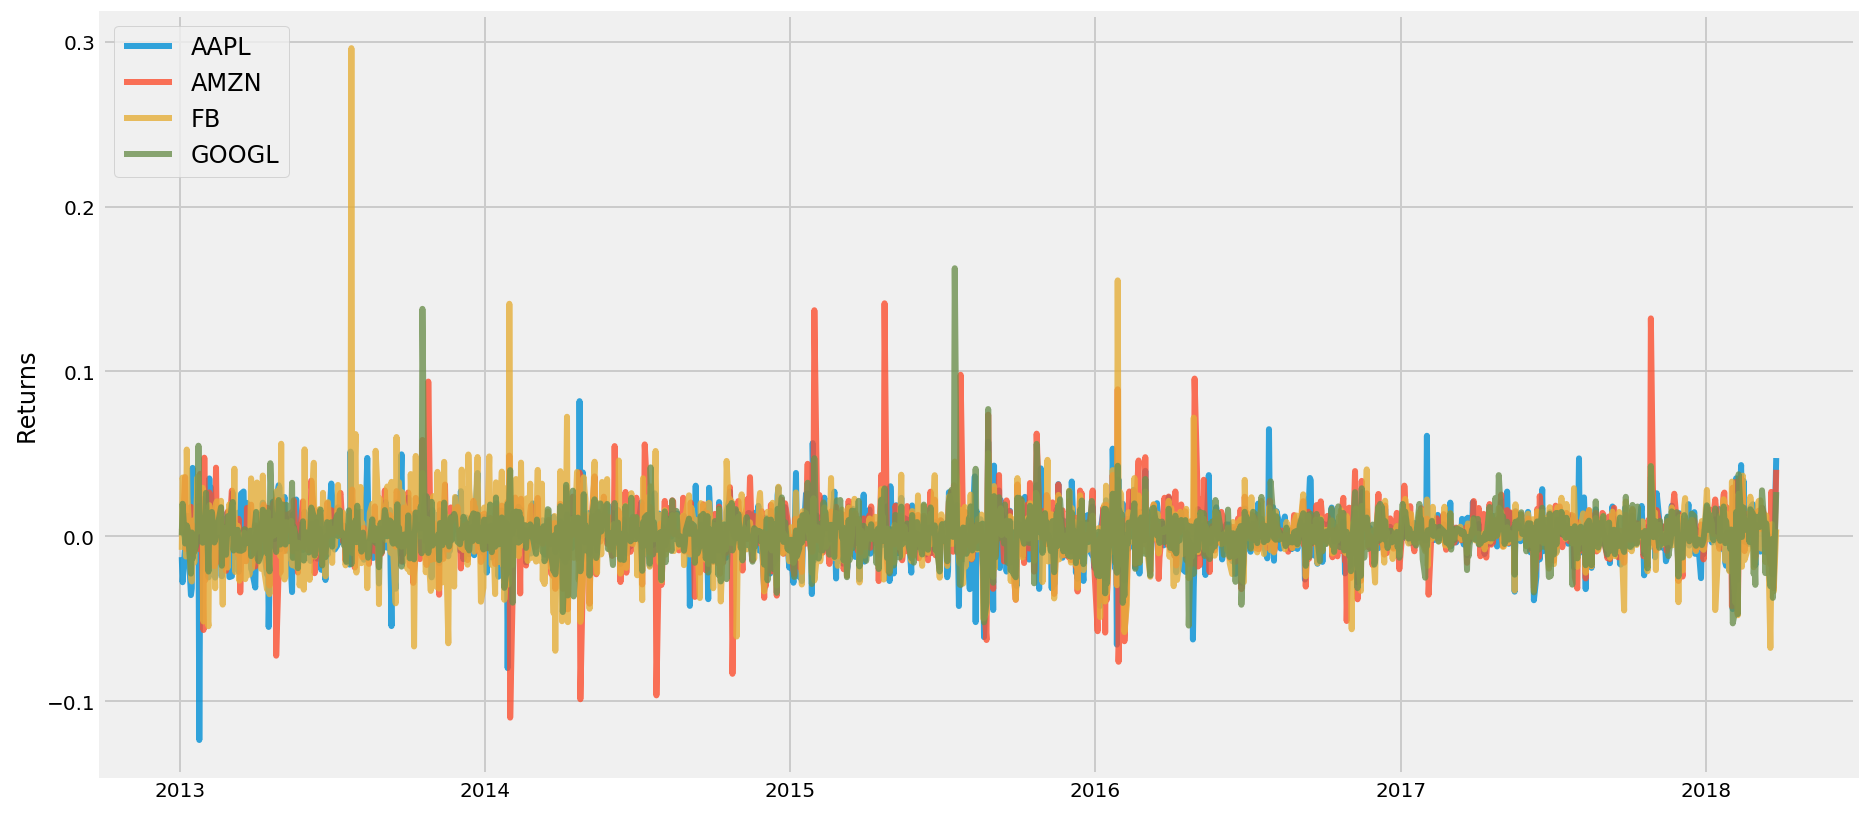

In [4]:
# Plot the prices of the stocks

plt.figure(figsize=(14, 7))
for c in table.columns:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')

# Plot the returns of the stocks

returns = table.pct_change()
returns.head()
plt.figure(figsize=(14, 7))
for c in returns.columns:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns')

# Mean returns

mean_returns = returns.mean()
cov_matrix = returns.cov()
print(cov_matrix)
mean_returns.head()

### Simulation of portfolios

In [5]:
#Number of portfolios
num_portfolios = 1000

#Create an array to store the results: the first 3 elements are reserved for the portfolio values, the other 4 for the single stocks
results = np.zeros((3+4,num_portfolios))


#Loop over the porfolios
for i in range(num_portfolios):
    
    #Select random weights, such that the sum does not exceed 1
    weights = np.random.random(4)
    weights = weights/ np.sum(weights)
    
    #Calculate portfolio returns and volatility for 252 trading days
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #Store the results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = results[0,i] / results[1,i]
    
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

#Convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=['Returns','Volatility','Sharpe Ratio',stocks[0],stocks[1],stocks[2],stocks[3]])
results_frame.head()

,Returns,Volatility,Sharpe Ratio,AAPL,AMZN,GOOGL,FB
0,0.264588,0.186948,1.415301,0.356964,0.168834,0.126754,0.347448
1,0.302807,0.200860,1.507556,0.199732,0.250782,0.258795,0.290692
2,0.249586,0.186670,1.337043,0.461551,0.111842,0.108488,0.318119
3,0.291619,0.198649,1.468010,0.412106,0.214591,0.264866,0.108437
4,0.247291,0.191111,1.293965,0.562363,0.139923,0.084770,0.212944


### Find and plot optimal portfolios

Maximum Sharpe Ratio Portfolio:
 Returns         0.334055
Volatility      0.216293
Sharpe Ratio    1.544451
AAPL            0.227556
AMZN            0.426882
GOOGL           0.286246
FB              0.059316
Name: 171, dtype: float64
Minimum Risk Portfolio:
 Returns         0.239441
Volatility      0.185412
Sharpe Ratio    1.291402
AAPL            0.407412
AMZN            0.094346
GOOGL           0.050487
FB              0.447756
Name: 109, dtype: float64


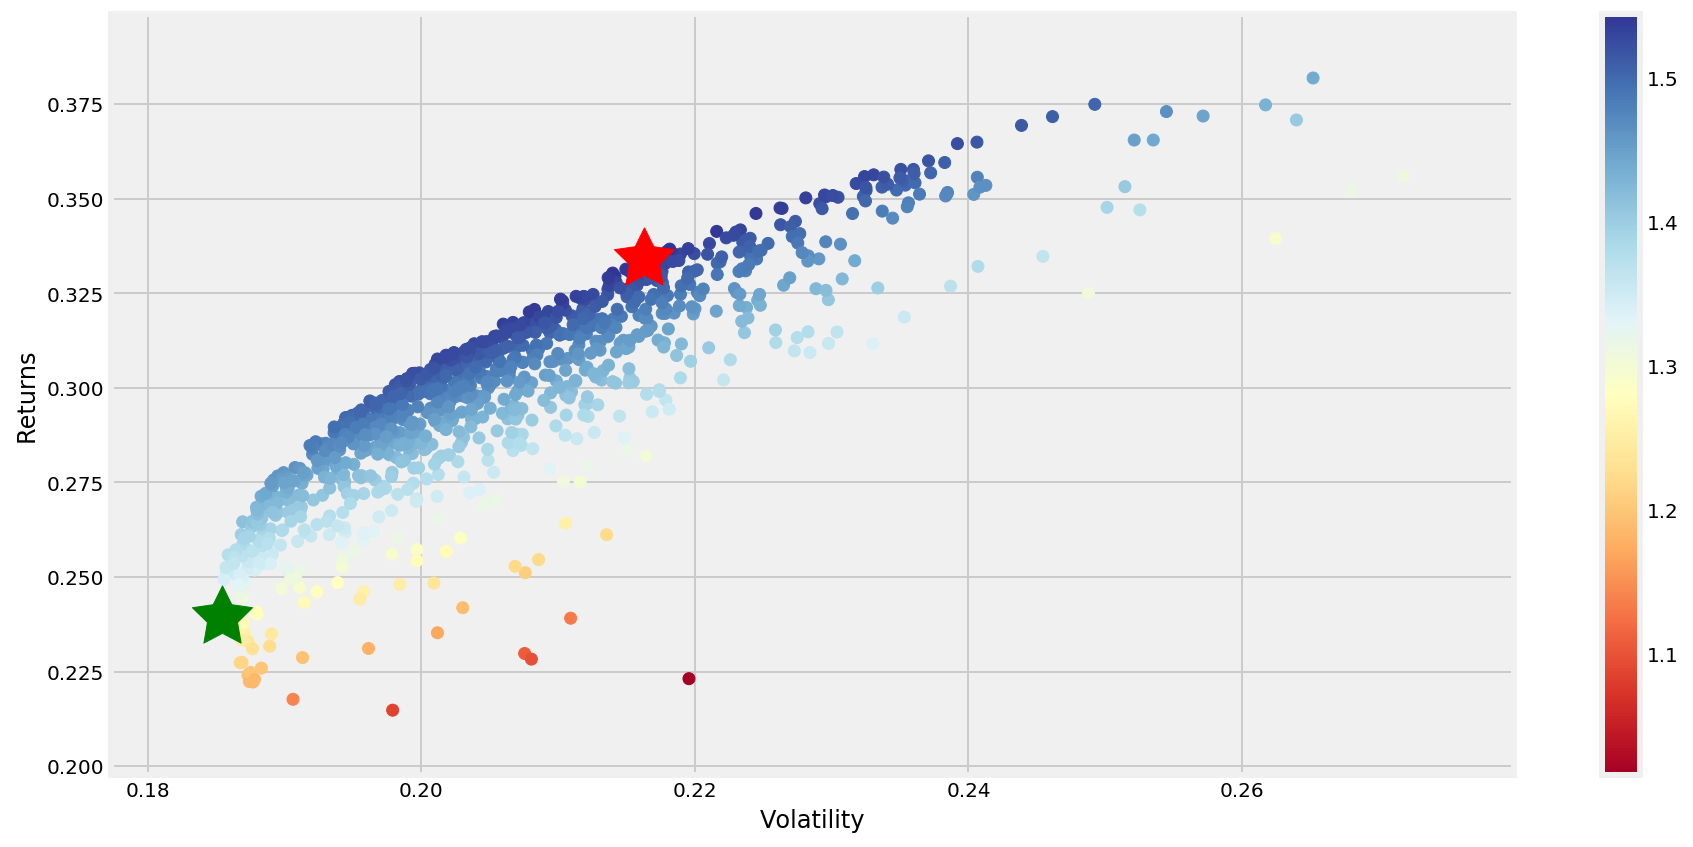

In [6]:
#Find the portfolio with the highest Sharpe Ratio
max_sharpe = results_frame.iloc[results_frame['Sharpe Ratio'].idxmax()]

#Locate the positon of the portfolio with the minimum standard deviation
min_vol = results_frame.iloc[results_frame['Volatility'].idxmin()]

#Create scatter plot coloured by Sharpe Ratio
plt.figure(figsize=(14, 7))
plt.scatter(results_frame['Volatility'],results_frame['Returns'],c=results_frame['Sharpe Ratio'],cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

#Mark the highest Sharpe Ratio portfolio with a red star
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=1000)
#Mark the highest Sharpe Ratio portfolio with a green star
plt.scatter(min_vol[1],min_vol[0],marker=(5,1,0),color='g',s=1000)

#Print out the performance for optimal portfolios
print('Maximum Sharpe Ratio Portfolio:\n', max_sharpe)
print('Minimum Risk Portfolio:\n', min_vol)

## Simulation of portfolios of correlated and uncorrelated stocks 

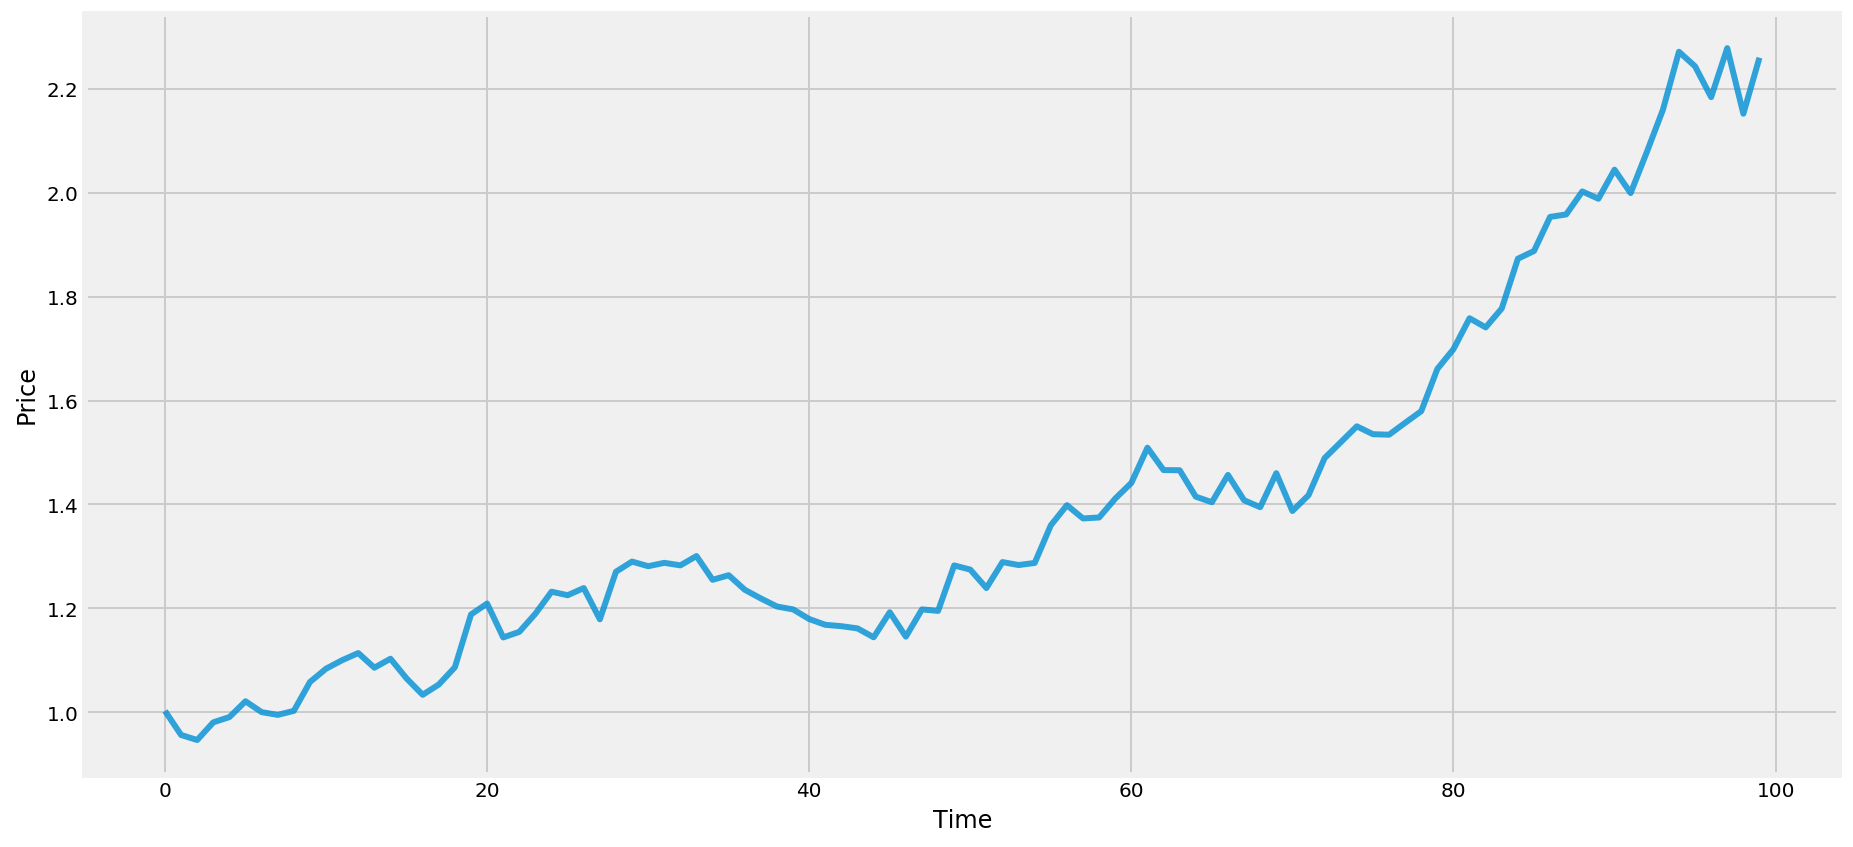

In [7]:
# Simulate price movement of one single stock
returns_1 = np.random.normal(1.01, 0.03, 100)
price_1 = np.cumprod(returns_1)
plt.figure(figsize=(14, 7))
plt.plot(price_1, lw=3, alpha=0.8,label=c)
plt.xlabel('Time')
plt.ylabel('Price');

### Correlated Stocks

Mean Return: 1.0073270421984724
Volatility: 0.027627133510642974
Sharpe Ratio: 36.46151135478509


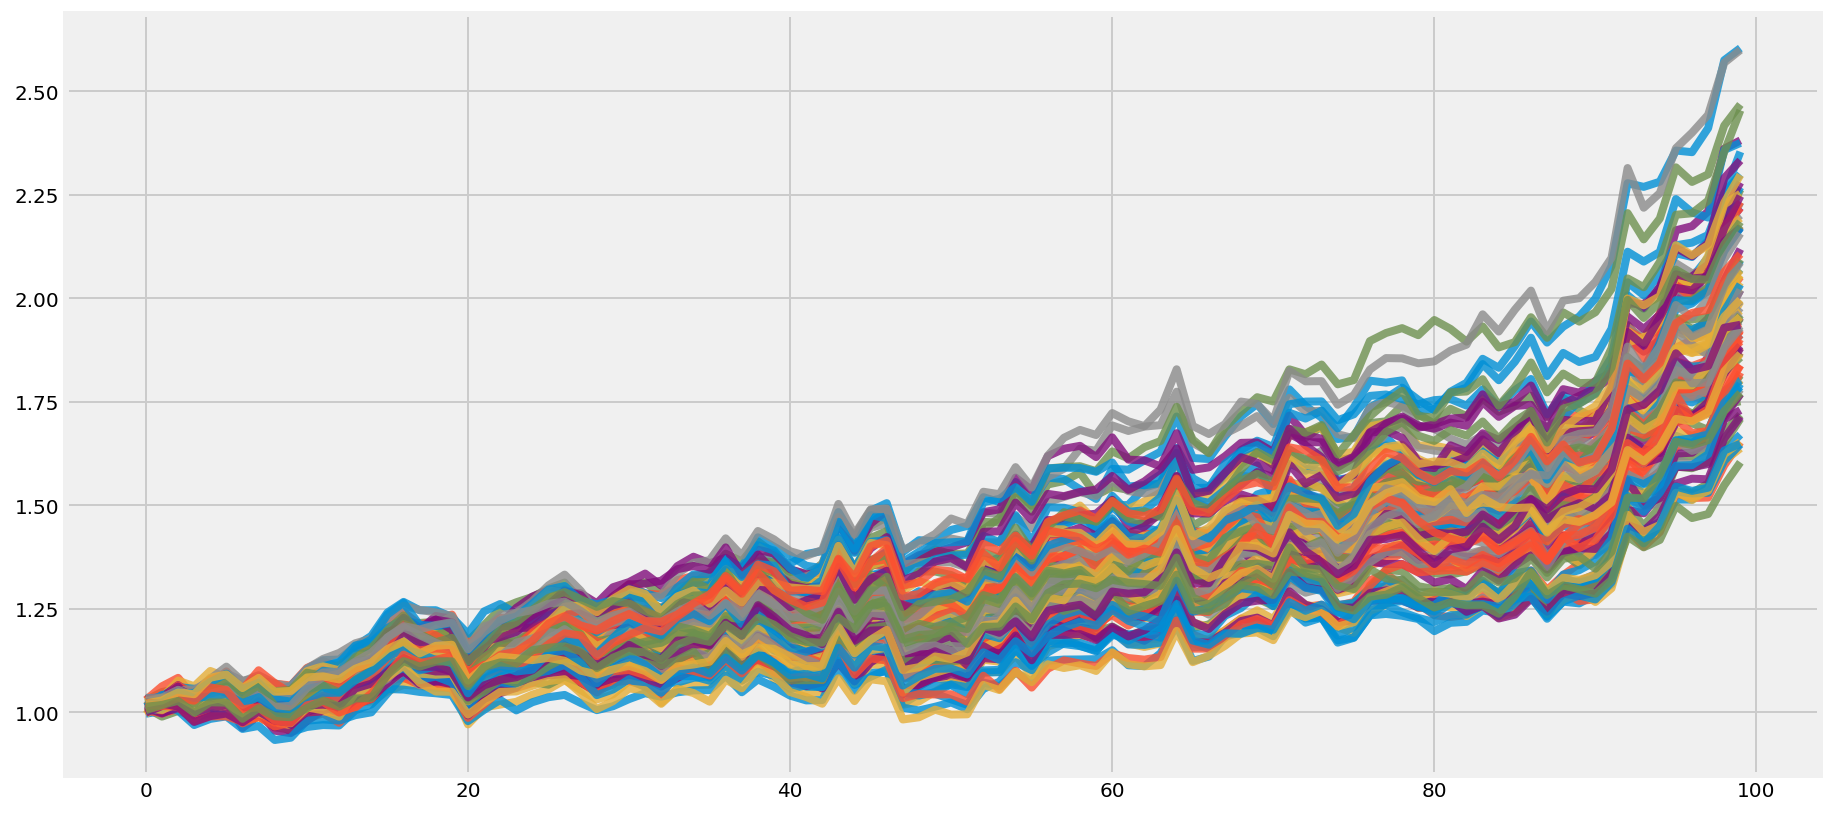

In [8]:
# Simulate a portfolio of N correlated stocks with equal weights
# Number of stocks
N = 100
# Number of trading days
D = 100

# Create arrays with zeros
returns_2 = np.zeros((N, D))
price_2 = np.zeros((N, D))
# First stock
returns_2[0] = np.random.normal(1.01, 0.03, D)
returns_st = returns_2[0]
price_2[0] = np.cumprod(returns_st)
plt.figure(figsize=(14, 7))
plt.plot(price_2[0], lw=3, alpha=0.8,label=c)

# Now loop over the entire portfolio

for i in range(1,N):
    returns_2[i] = returns_st + np.random.normal(0.001, 0.01, D)
    price_2[i] = np.cumprod(returns_2[i])
    plt.plot(price_2[i], alpha=0.8)

mean_returns_2 = np.mean(returns_2, axis=0)
returns_std_2 = np.std(mean_returns_2)
print('Mean Return:', np.mean(mean_returns_2))
print('Volatility:', returns_std_2)
print('Sharpe Ratio:', np.mean(mean_returns_2)/returns_std_2)





### Uncorrelated Stocks

Mean Return: 1.0097326109814215
Volatility: 0.00305681300497422
Sharpe Ratio: 330.3220083591398


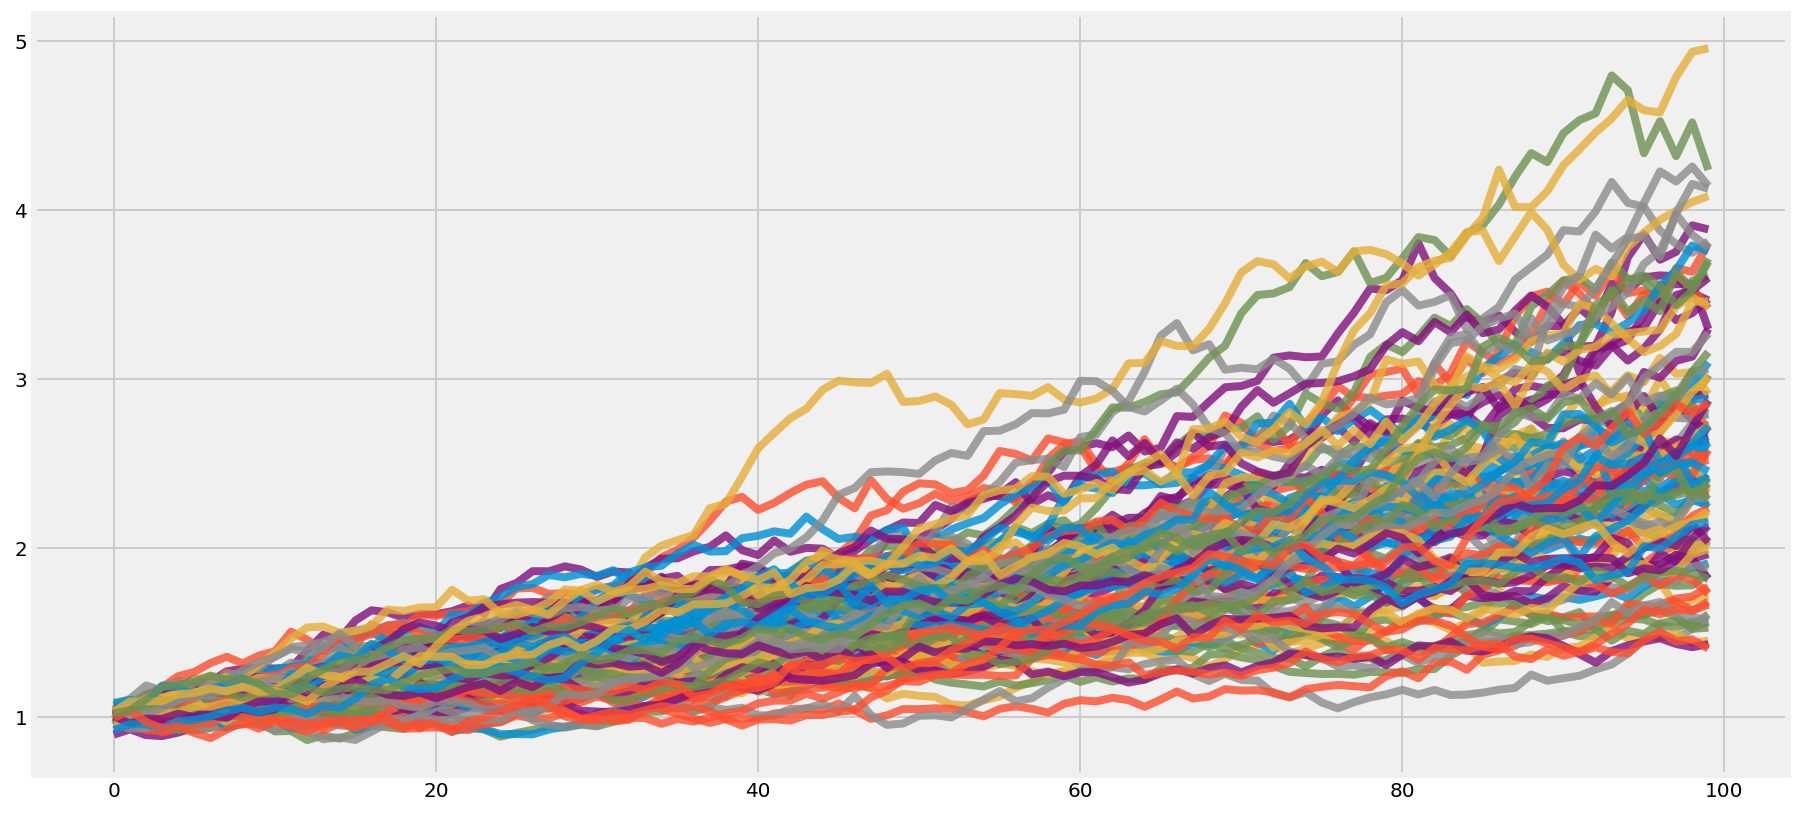

In [9]:
# Simulate a portfolio of N uncorrelated stocks with equal weights
# Number of stocks
N = 100
# Number of trading days
D = 100

# Create arrays with zeros
returns_3 = np.zeros((N, D))
price_3 = np.zeros((N, D))

# First stock
returns_3[0] = np.random.normal(1.01, 0.03, D)
returns_st = returns_3[0]
price_3[0] = np.cumprod(returns_st)
plt.figure(figsize=(14, 7))
plt.plot(price_3[0], lw=3, alpha=0.8,label=c)

# Now loop over the entire portfolio

for i in range(1,N):
    returns_3[i] = np.random.normal(01.01, 0.03, D)
    price_3[i] = np.cumprod(returns_3[i])
    plt.plot(price_3[i], alpha=0.8)
    
mean_returns_3 = np.mean(returns_3, axis=0)
returns_std_3 = np.std(mean_returns_3)
print('Mean Return:', np.mean(mean_returns_3))
print('Volatility:', returns_std_3)
print('Sharpe Ratio:', np.mean(mean_returns_3)/returns_std_3)
    

### Impact of portfolio size on the volatility
As it can be seen from the graph below the volatility of a portfolio of uncorrelated stocks decreases with an increasing number of stocks. However, the returns do not decrease. 

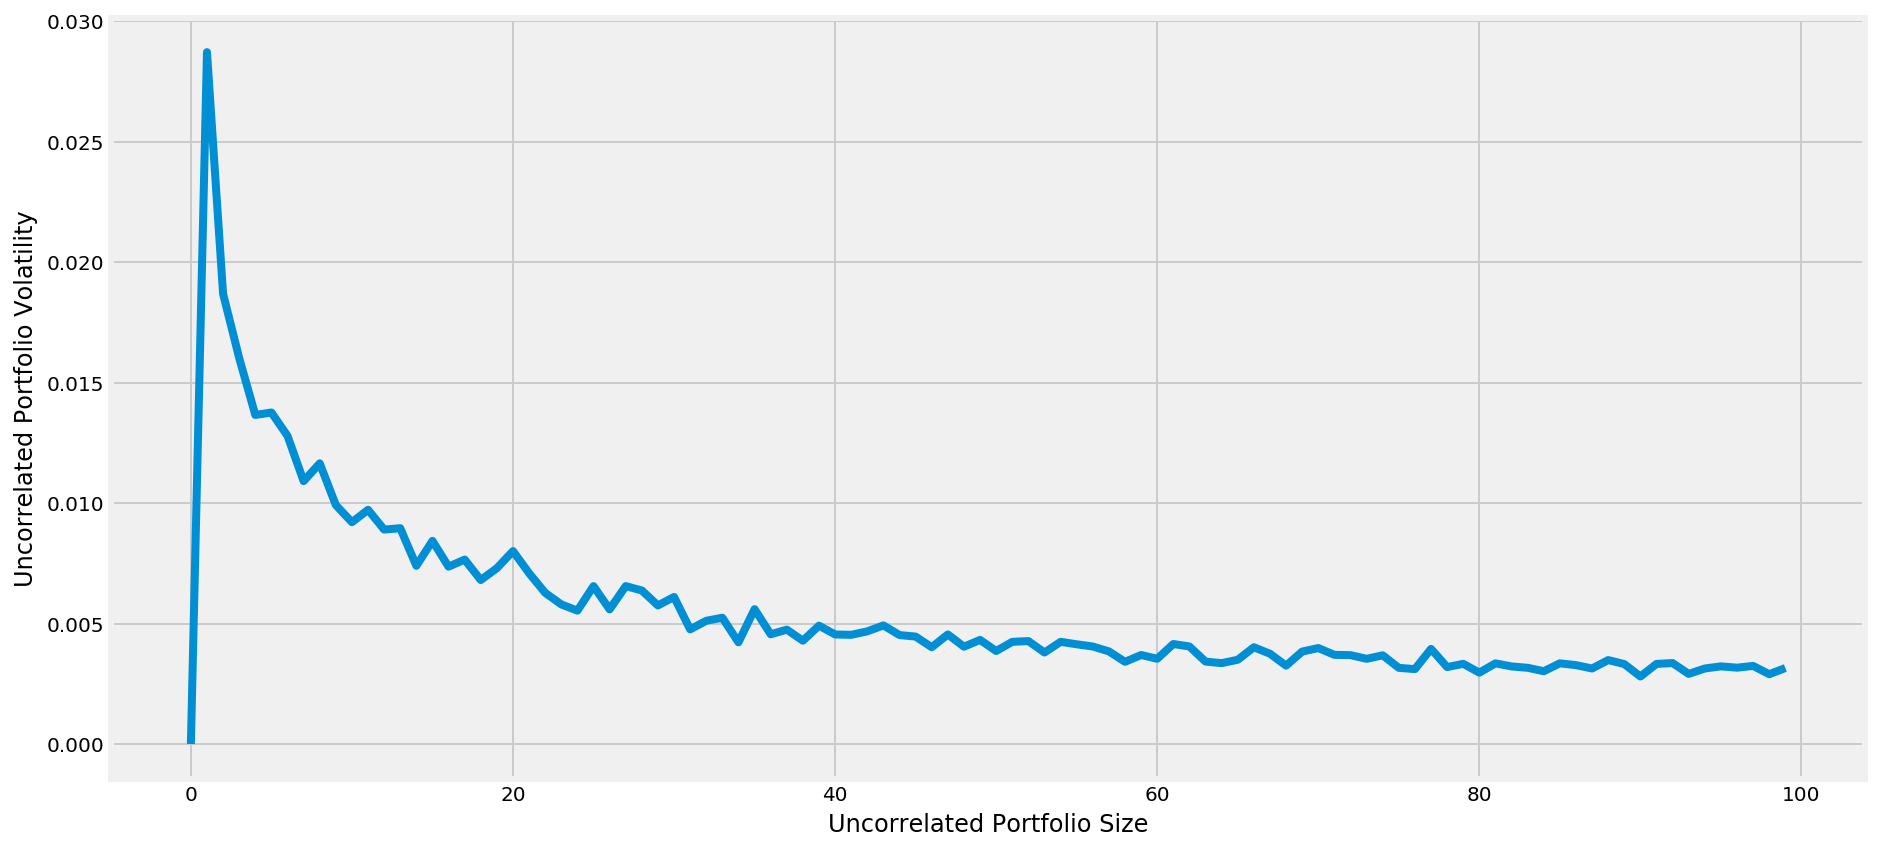

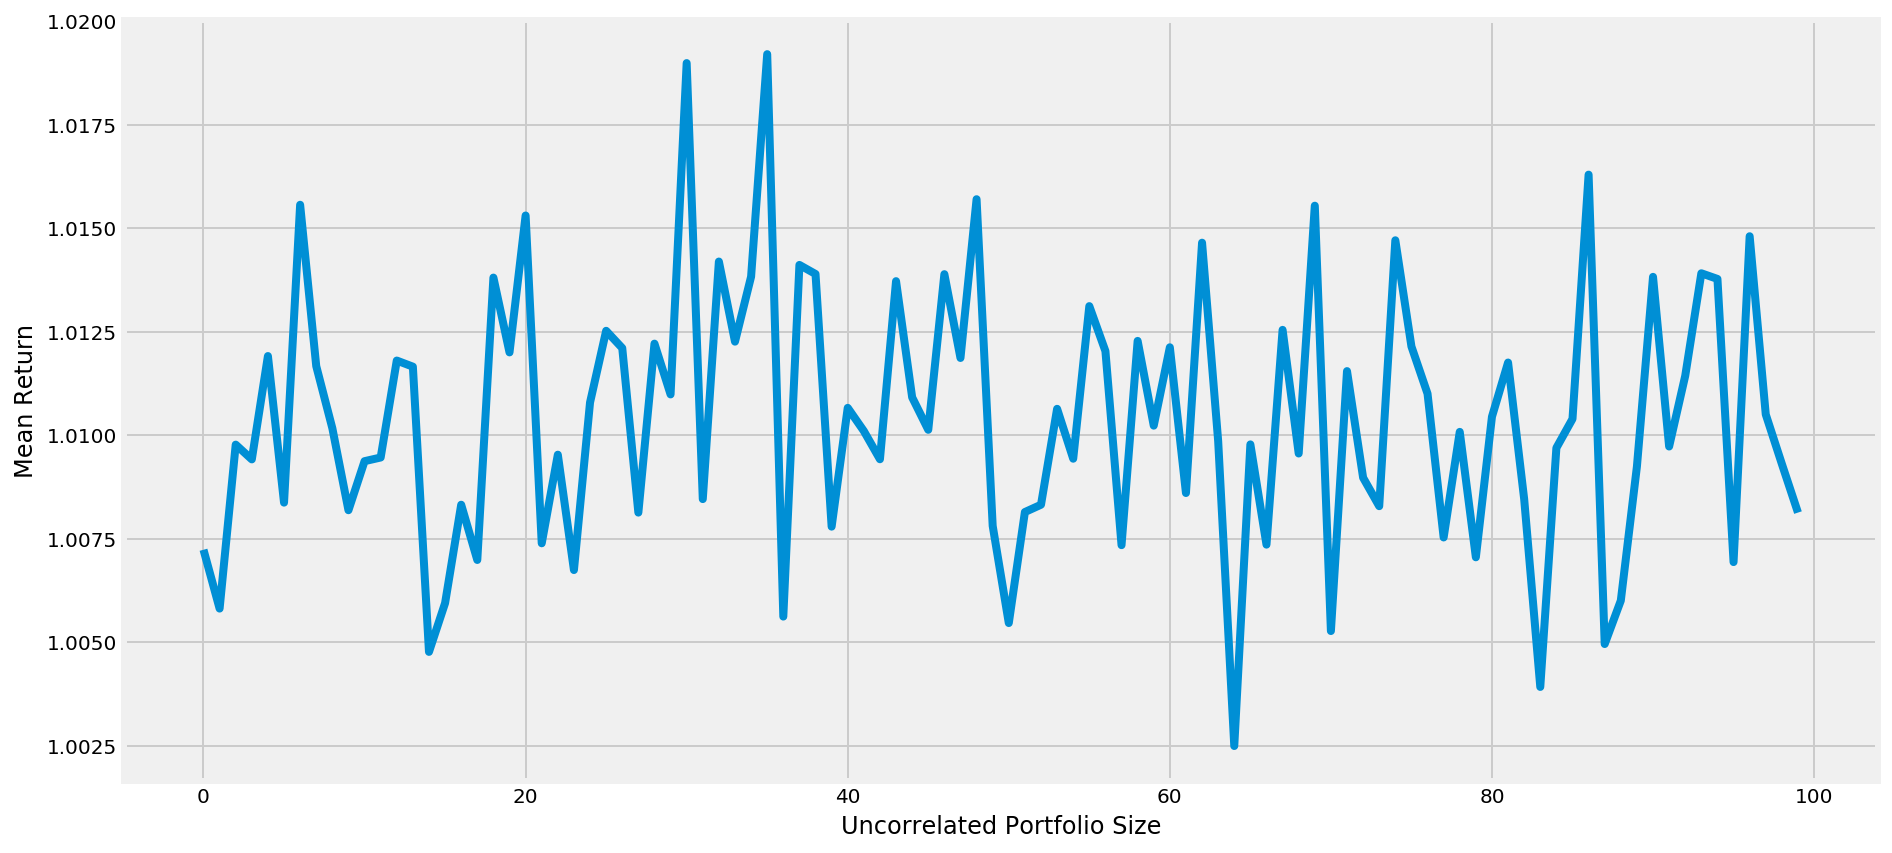

In [10]:
# 
# Number of stocks
N = 100
# Number of trading days
D = 100

returns_4 = np.zeros((D,1))

for j in range(1,N):

    # Create arrays with zeros
    returns_3 = np.zeros((j, D))
    price_3 = np.zeros((j, D))

    # First stock
    returns_3[0] = np.random.normal(1.01, 0.03, D)
    returns_st = returns_3[0]
    price_3[0] = np.cumprod(returns_st)
    
    # Now loop over the entire portfolio
    for i in range(1,j):
        returns_3[i] = np.random.normal(01.01, 0.03, D)
        price_3[i] = np.cumprod(returns_3[i])
        
    mean_returns_4 = np.mean(returns_3, axis=0)
    returns_4[j] = np.std(mean_returns_4)
    

plt.figure(figsize=(14, 7))
plt.plot(returns_4)
plt.xlabel('Uncorrelated Portfolio Size')
plt.ylabel('Uncorrelated Portfolio Volatility'); 

plt.figure(figsize=(14, 7))
plt.plot(mean_returns_4)
plt.xlabel('Uncorrelated Portfolio Size')
plt.ylabel('Mean Return'); 
    